In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import scienceplots
plt.style.use(['science','no-latex'])
from matplotlib import patches as mpatches
from matplotlib import lines as mlines

from itertools import product

from qiskit import QuantumCircuit

In [2]:
results_folder = "results/"
idx = "001"

with open(results_folder + f"shuttling_A_{idx}.txt", "r") as f:
    lines = f.readlines()
    gate_settings = lines[1].split(": ")[1].strip()
parameters = json.load(open(gate_settings, "r"))

output_file = f"shuttling_A_{idx}.csv"
data = pd.read_csv(results_folder + output_file)

In [3]:
# set same color for same circuit
circuit_names = data["name"].unique()
colors_all = [c for c in sns.color_palette("colorblind")]
colors_dict = {name: color for name, color in zip(circuit_names, colors_all)}

In [4]:
T_1 = parameters["decoherence_times"]["T1"]
T_2 = parameters["decoherence_times"]["T2"]
T_eff = T_1 * T_2 / (T_1 + T_2)
t_gate = parameters["durations"]["default"]
f_cx = parameters["fidelities"]["cx"]
t_cx = parameters["durations"]["cx"]
v_param = parameters["shuttling"]["speed"]
d = parameters["shuttling"]["inter_qubit_distance"]
activ_time = parameters["shuttling"]["fixed_activ_deactiv"] if parameters["shuttling"]["fixed_activ_deactiv"] != 0 else parameters["shuttling"]["activate_time"] + parameters["shuttling"]["deactivate_time"]

## 1. Substitute SWAPS with shuttling

In [5]:
# load data with different parameters
output_file = f"shuttling_B_001.csv"
data_distance = pd.read_csv(results_folder + output_file)

In [6]:
fs =  np.logspace(-0.1, -4, 21) 

data_pre_plot = pd.DataFrame(columns=["name", "num_qubits", "T_eff", "f", "swap_chains", "distance"])
num_qubits = [80]
data_filter = data_distance.query("num_qubits == @num_qubits")
for row in data_filter.iterrows():
    row = row[1]
    for f in fs:
        T_eff_normal = (row["idle_normal"] - row["idle_normal_sh"]) / (3 * row["swap_normal"] * np.log(1-f)) / t_gate
        # T_eff_chain = (row["idle_normal"] - row["idle_chains_sh"]) / (3 * row["swap_normal"] * np.log(1-f)) / t_gate
        t_eff_parts = (row["idle_normal"] - (row["idle_sh_parts"] + row["idle_qc_parts"])) / (3 * row["swap_normal"] * np.log(1-f)) / t_gate
        # add to data_plot
        data_pre_plot = pd.merge(data_pre_plot, pd.DataFrame([[row["name"], row["num_qubits"], T_eff_normal, f, "direct", row["distance"]],
                                                                        # [row["name"], row["num_qubits"], T_eff_chain, f, "chain", row["d"]],
                                                                        [row["name"], row["num_qubits"], t_eff_parts, f, "parts", row["distance"]]],
                                                     columns=["name", "num_qubits", "T_eff", "f", "swap_chains", "distance"]), how="outer")

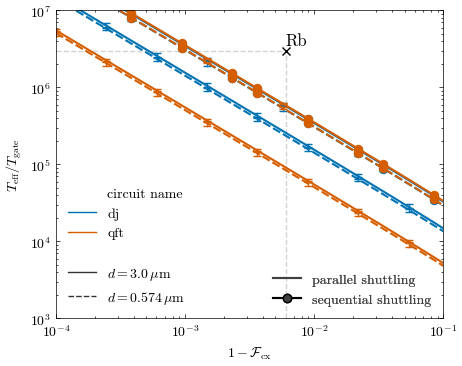

In [7]:
swap_chains = ['direct', 'parts']
names = ["dj", "qft"]
cs = [colors_dict[name] for name in circuit_names if name in names]
data_plot = data_pre_plot.query("swap_chains == @swap_chains and name in @names")
fig, ax = plt.subplots(figsize=(5, 4))

distances = data_plot["distance"].unique()

ax.hlines(T_eff / t_gate, 1e-4, 1-f_cx, color='lightgrey', linestyle='--')
ax.vlines(1-f_cx, 1e3, T_eff / t_gate, color='lightgrey', linestyle='--')
ax.annotate( r"Rb", (1-f_cx, T_eff / t_gate * 1.2), fontsize=12)

sns.lineplot(data=data_plot[data_plot["swap_chains"] == "direct"], x='f', y='T_eff', hue='name', ax=ax, err_style="bars", style='distance',
             style_order=distances, palette=cs, linewidth=1.5, errorbar="sd", err_kws={"capsize": 3, "errorevery": 2})
sns.lineplot(data=data_plot[data_plot["swap_chains"] == "parts"], x='f', y='T_eff', hue='name', ax=ax, err_style="bars", style='distance',
             style_order=distances, palette=cs, linewidth=1.5, markers=['o', 'o'], markevery=0.1, markeredgecolor=None, legend=False, errorbar="sd",
             err_kws={"capsize": 3, "errorevery": 3})
ax.plot([1-f_cx], [T_eff / t_gate], 'x', color='black')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r"$1 - \mathcal{F}_\mathrm{cx}$")
ax.set_ylabel(r"$T_\mathrm{eff} / T_\mathrm{gate}$")

ax.set_xlim(1e-4, 1e-1)
ax.set_ylim(1e3, 1e7)

# change legend labels
handles, labels = ax.get_legend_handles_labels()
labels[0] = 'circuit name'
labels[-3:] = [' ', r"$d = 3.0 \, \mu$m",  r"$d = 0.574\, \mu$m"]
ax_orig = ax.legend(handles, labels, loc='lower left')

# add second legend for different d
legend_hatches = [mlines.Line2D([], [], linewidth=1.5, color='0.25', marker='', markerfacecolor='white', markeredgecolor=None),
                    mlines.Line2D([], [], linewidth=1.5, markersize=6, color='black', marker='o', markerfacecolor='0.25', markeredgecolor=None)]
# labels with grey background
labels = ['parallel shuttling', 'sequential shuttling']
legend_hatches = ax.legend(handles=legend_hatches, labels=labels, loc='lower right', title="")
for text in legend_hatches.get_texts():
    text.set_color("0.25")
ax.add_artist(legend_hatches)
ax.add_artist(ax_orig)

# save figure
fig.savefig('figures/shuttling.pdf', bbox_inches='tight')


## 2. Shuttling Layers

In [25]:
names = ["qft", "ghz",  "dj", "graphstate"]
cs = [colors_dict[name] for name in circuit_names if name in names]
data_filter = data.query("name in @names and num_qubits >= 30")
data_filter.loc[:,["idle_activ"]] =  activ_time * data_filter["swap_normal"] * data_filter["num_qubits"]
data_filter.loc[:,["idle_sh_parts_total"]] = data_filter["idle_qc_parts"] + data_filter["idle_sh_parts"]
data_filter.loc[:,["idle_sh_parts_total_rel"]] = [1] * len(data_filter)
data_filter.loc[:,["idle_sh_parts_rel"]] = data_filter["idle_sh_parts"] / data_filter["idle_sh_parts_total"]
data_filter.loc[:,["idle_activ_rel"]] = data_filter["idle_activ"] / data_filter["idle_sh_parts_total"]

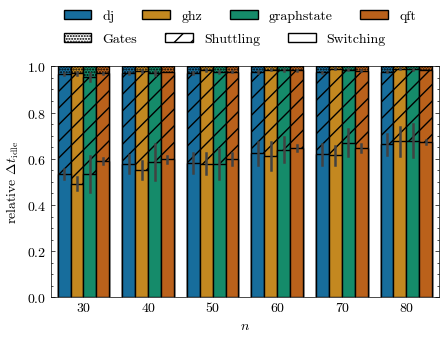

In [43]:

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5, 3))
fig.subplots_adjust(hspace=0.03)
sns.barplot(data=data_filter, x="num_qubits", y="idle_sh_parts_total_rel", hue="name", ax=ax, palette=cs, errorbar="sd")
sns.barplot(data=data_filter, x="num_qubits", y="idle_sh_parts_rel", hue="name", ax=ax, palette=cs, errorbar="sd")
sns.barplot(data=data_filter, x="num_qubits", y="idle_activ_rel", hue="name", ax=ax, palette=cs, errorbar="sd")

# add hatch to shuttling bars
for i, bar in enumerate(ax.patches):
    if i < len(ax.patches)/3:
        bar.set_hatch('......')
    elif i < 2 * len(ax.patches)/3:
        bar.set_hatch('//')
    else:
        bar.set_hatch('')

    bar.set_edgecolor('black')

# only use first half of labels in legend
handles, labels = ax.get_legend_handles_labels()

pre_legend_hatches = [mpatches.Patch(facecolor='white', edgecolor='black', hatch='......', label='Gates'), 
                    mpatches.Patch(facecolor='white', edgecolor='black', hatch='//', label='Shuttling'),
                    mpatches.Patch(facecolor='white', edgecolor='black', hatch='', label='Switching')]
legend_hatches = ax.legend(handles=pre_legend_hatches, loc='upper left', bbox_to_anchor=(0.0, 1.2), ncol=5, title="")
ax.add_artist(legend_hatches)
ax.legend(handles[2*len(handles)//3:], labels[2*len(labels)//3:], loc='upper left', bbox_to_anchor=(0.0, 1.3), ncol=5, title="")
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"relative $ \Delta t_{\mathrm{idle}}$")
ax.set_ylim(0.0,1)

plt.savefig("figures/idle_times.pdf", bbox_inches='tight')

## 3. Shuttling layers

In [13]:
data_filter = data.copy()
data_filter["parts_reduced_rel"] = (data_filter["num_parts"] - data_filter["num_parts_reconfigure"])/ data_filter["num_parts"]

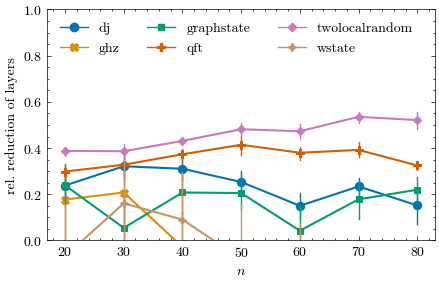

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
cs = [colors_dict[name] for name in data_filter["name"].unique()]
sns.lineplot(data=data_filter, x="num_qubits", y="parts_reduced_rel", hue="name", style="name", dashes=False, markers=True, 
             ax=ax, err_style="bars", palette=cs, linewidth=1.5, markeredgecolor=None)
ax.set_ylim(0, 1)
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"rel. reduction of layers")
ax.legend(title="", loc="upper left", ncol=3)

fig.savefig("figures/layers_shuttling.pdf", bbox_inches="tight")

## 4. Vary speed

$$v = d / (3*t_\mathrm{cx} - t_\mathrm{activate} - 3 T_\mathrm{eff} \ln(f))

In [8]:
fs = [f_cx, 0.9975, 0.999]
t = 20
int_radii = [2, 5]
num_qubits = np.linspace(1,600,1000)


In [9]:
columns = ["fidelity", "velocity", "t_swap", "num_qubits"]
data_speed = pd.DataFrame(columns=columns)

In [10]:
vs = []
# for t in t_swap:
for f in fs:
    for r in int_radii:
        v = r * 2 *d / (3 * t_cx - 2*t - 3 * T_eff * np.log(f) / num_qubits)
        v[v<0] = np.nan
        vs.append(v)
len(vs)

6

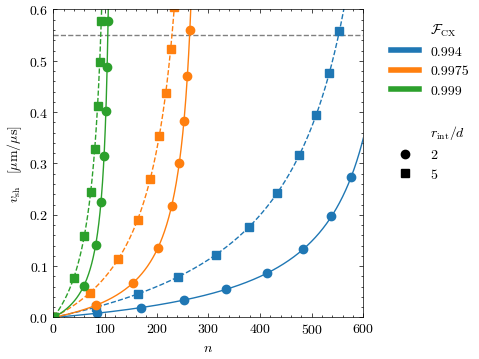

In [12]:
from matplotlib.lines import Line2D
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
markers = ["o", "s", "v", "D", "P"]
styles = ["-", "--", "-.", ":", "-"]

fig, ax = plt.subplots(figsize=(4, 4))

ax.hlines(v_param,0,600, color="grey", linestyle="dashed")

for idx_t, t in enumerate(fs):
    for idx_dist, dist in enumerate(int_radii):
        idx = idx_t * len(int_radii) + idx_dist
        ax.plot(num_qubits, vs[idx], 
                color = colors[idx_t],
                marker = markers[idx_dist],
                linestyle = styles[idx_dist],
                markevery = 0.1,
        )
legend_elements = []
legend_elements.append(Line2D([0], [0], color="white", lw=0, label=r"$\mathcal{F}_\mathrm{CX}$"))
for idx_t, t in enumerate(fs):
        legend_elements.append(Line2D([0], [0], color=colors[idx_t], lw=4, label=r"" + f"{t}"))
legend_elements.append(Line2D([0], [0], color="white", lw=0, label=""))
legend_elements.append(Line2D([0], [0], color="white", lw=0, label=r"$r_\mathrm{int} / d$"))
for idx_dist, dist in enumerate(int_radii):
        legend_elements.append(Line2D([0], [0], color="black", marker=markers[idx_dist], lw=0, label=f"{dist}"))
ax.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.05, 1), frameon=False, ncol=1)

ax.set_ylim(0, 0.6)
ax.set_xlim(0, 600)
ax.set_xlabel(r"$n$")
ax.set_ylabel(r"$v_\mathrm{sh} \quad [\mu \mathrm{m} / \mu \mathrm{s}]$")

fig.savefig("figures/shuttling_speed.pdf", bbox_inches="tight")